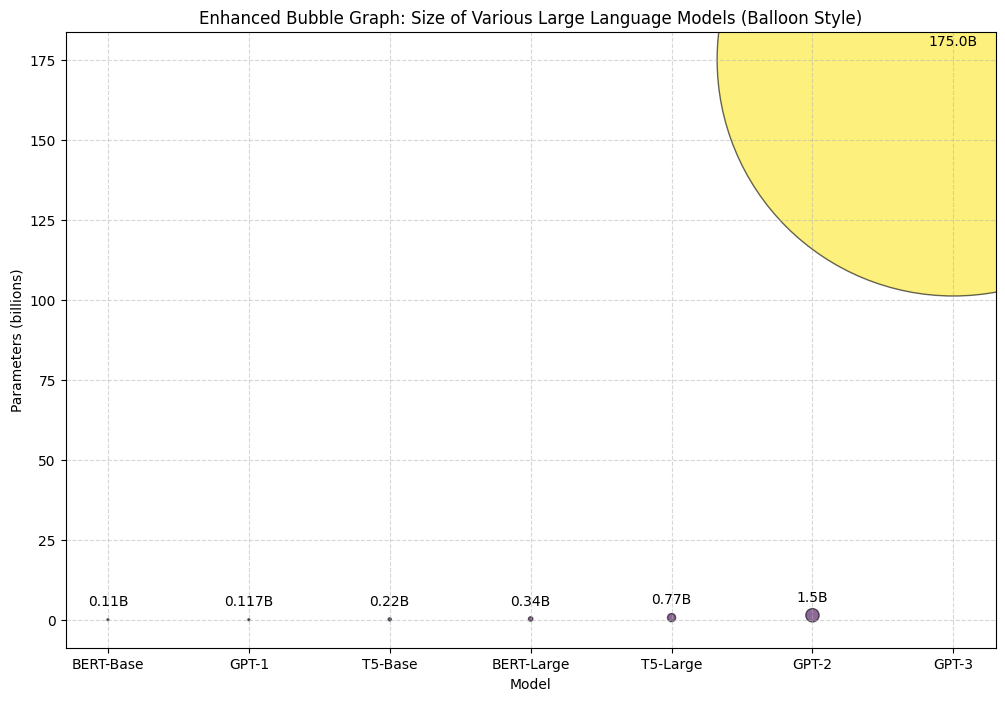

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm

# Create a DataFrame to hold the data
data = {
    'Model': ['GPT-1', 'GPT-2', 'GPT-3', 'BERT-Base', 'BERT-Large', 'T5-Base', 'T5-Large'],
    'Parameters (billions)': [0.117, 1.5, 175, 0.11, 0.34, 0.22, 0.77]
}

df = pd.DataFrame(data)

# Sorting the DataFrame by the number of parameters
df = df.sort_values('Parameters (billions)', ascending=True)

# Adjusting the bubble graph to use a more visually appealing marker style
plt.figure(figsize=(12, 8))
colors = cm.viridis(df['Parameters (billions)'] / df['Parameters (billions)'].max())

# Scaling bubble sizes non-linearly for better visual differentiation
bubble_size = (df['Parameters (billions)'] ** 1.5) * 50

plt.scatter(df['Model'], df['Parameters (billions)'], s=bubble_size, alpha=0.6, color=colors, marker='o', edgecolors='black')
plt.xlabel('Model')
plt.ylabel('Parameters (billions)')
plt.title('Enhanced Bubble Graph: Size of Various Large Language Models (Balloon Style)')
plt.grid(True, linestyle='--', alpha=0.5)

# Adding annotations to each bubble for better clarity
for i, txt in enumerate(df['Parameters (billions)']):
    plt.annotate(f'{txt}B', (df['Model'].iloc[i], df['Parameters (billions)'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Show the plot
plt.show()


PlatUML Decoder only CHAT GPT  architeacture



@startuml
start

:Tokenize Input;

:Apply Token Embeddings;
note right
Converts tokens to vector representations
end note

:Apply Positional Encodings;
note right
Adds sequence information to embeddings
end note

repeat :Process in Transformer Layer;
  :Masked Self-Attention;
  note right
  Focuses on relevant tokens
  end note
  :Layer Normalization;
  :Feed-Forward Neural Network;
  :Layer Normalization;
repeat while (More layers?)

:Output Linear Layer;
note right
Maps transformer output to vocabulary size
end note

:Softmax Function;
note right
Converts to probability distribution
end note

stop
@enduml

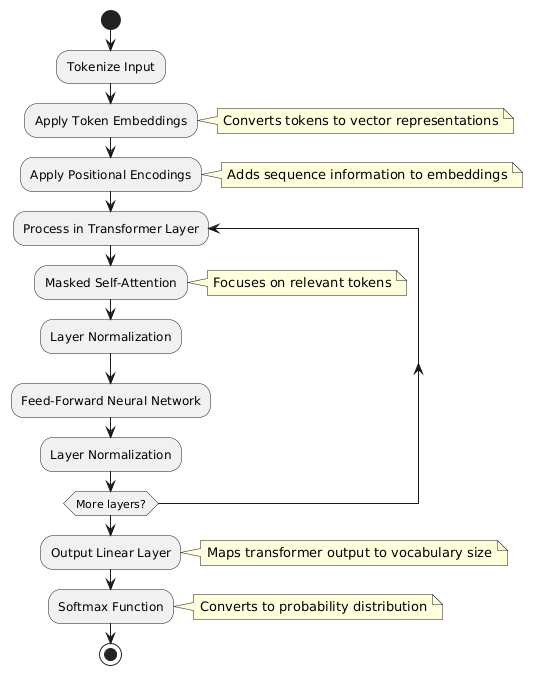

##Custom GPT Architecture

In [ ]:
!pip install torch transformers datasets


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import PreTrainedTokenizerFast, AdamW
from datasets import load_dataset
import math


In [ ]:
class GPT2Config:
    def __init__(self, vocab_size=50257, n_positions=1024, n_ctx=1024, n_embd=768, n_layer=12, n_head=12, n_inner=3072):
        self.vocab_size = vocab_size
        self.n_positions = n_positions
        self.n_ctx = n_ctx
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_inner = n_inner
        self.activation_function = 'gelu'
        self.resid_pdrop = 0.1
        self.embd_pdrop = 0.1
        self.attn_pdrop = 0.1
        self.layer_norm_epsilon = 1e-5
        self.initializer_range = 0.02


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super(MultiHeadAttention, self).__init__()
        assert config.n_embd % config.n_head == 0

        self.n_head = config.n_head
        self.split_size = config.n_embd // config.n_head
        self.scale = 1 / math.sqrt(self.split_size)

        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

    def _split_heads(self, x):
        new_shape = x.size()[:-1] + (self.n_head, self.split_size)
        x = x.view(*new_shape)
        return x.permute(0, 2, 1, 3)

    def _merge_heads(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        new_shape = x.size()[:-2] + (x.size(-2) * x.size(-1),)
        return x.view(*new_shape)

    def forward(self, x):
        query, key, value = self.c_attn(x).split(self.split_size * self.n_head, dim=2)
        query = self._split_heads(query)
        key = self._split_heads(key)
        value = self._split_heads(value)

        attn_weights = torch.matmul(query, key.transpose(-2, -1)) * self.scale
        attn_weights = torch.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, value)
        attn_output = self._merge_heads(attn_output)
        attn_output = self.c_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)
        return attn_output


In [ ]:
class Block(nn.Module):
    def __init__(self, config):
        super(Block, self).__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, config.n_inner),
            nn.GELU(),
            nn.Linear(config.n_inner, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        attn_output = self.attn(self.ln_1(x))
        x = x + attn_output
        mlp_output = self.mlp(self.ln_2(x))
        x = x + mlp_output
        return x


In [ ]:
class GPT2(nn.Module):
    def __init__(self, config):
        super(GPT2, self).__init__()
        self.embed = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_embed = nn.Embedding(config.n_positions, config.n_embd)
        self.drop = nn.Dropout(config.embd_pdrop)
        self.layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, input_ids, position_ids):
        inputs_embeds = self.embed(input_ids)
        position_embeds = self.pos_embed(position_ids)
        hidden_states = inputs_embeds + position_embeds
        hidden_states = self.drop(hidden_states)

        for layer in self.layers:
            hidden_states = layer(hidden_states)

        hidden_states = self.ln_f(hidden_states)
        logits = self.head(hidden_states)
        return logits


In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, block_size):
        self.examples = []
        for text in texts:
            tokenized_text = tokenizer.encode(text)
            self.examples.extend([tokenized_text[i:i + block_size] for i in range(0, len(tokenized_text) - block_size + 1, block_size)])

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i], dtype=torch.long)

# Load dataset
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
texts = dataset['text']

# Initialize tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained('gpt2')

block_size = 128
train_dataset = TextDataset(texts, tokenizer, block_size)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


#Training Loop without visualization

In [ ]:
def train(model, dataloader, optimizer, device):
    model.train()
    for epoch in range(3):  # Change the number of epochs as needed
        for batch in dataloader:
            inputs = batch.to(device)
            position_ids = torch.arange(inputs.size(1), dtype=torch.long, device=inputs.device)
            position_ids = position_ids.unsqueeze(0).expand_as(inputs)

            optimizer.zero_grad()
            outputs = model(inputs, position_ids)
            shift_logits = outputs[..., :-1, :].contiguous()
            shift_labels = inputs[..., 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

            loss.backward()
            optimizer.step()

            print(f"Epoch: {epoch}, Loss: {loss.item()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2(GPT2Config())
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

train(model, train_dataloader, optimizer, device)


#Training Loop with Visualization

Epoch: 1, Loss: 3.3698156248911357
Epoch: 2, Loss: 0.8981502763173814
Epoch: 3, Loss: 0.3699967578910929


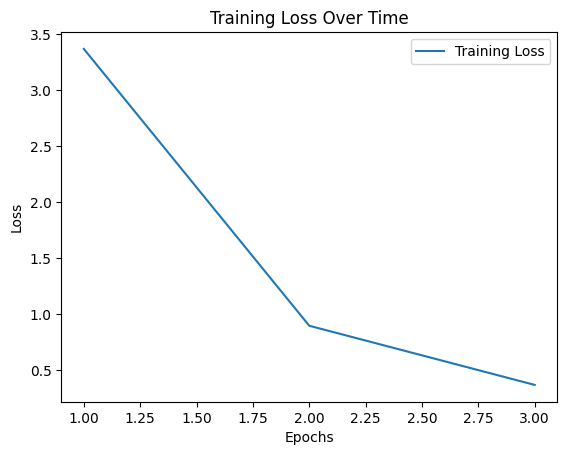

In [ ]:
import matplotlib.pyplot as plt

def train(model, dataloader, optimizer, device, num_epochs=3):
    model.train()
    loss_values = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in dataloader:
            inputs = batch.to(device)
            position_ids = torch.arange(inputs.size(1), dtype=torch.long, device=inputs.device)
            position_ids = position_ids.unsqueeze(0).expand_as(inputs)

            optimizer.zero_grad()
            outputs = model(inputs, position_ids)
            shift_logits = outputs[..., :-1, :].contiguous()
            shift_labels = inputs[..., 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        loss_values.append(avg_epoch_loss)
        print(f"Epoch: {epoch + 1}, Loss: {avg_epoch_loss}")

    return loss_values

# Training
num_epochs = 6
loss_values = train(model, train_dataloader, optimizer, device, num_epochs)

# Save the model
#torch.save(model.state_dict(), "./custom_gpt_model.pth")
#tokenizer.save_pretrained("./custom_gpt_tokenizer")

# Plot the training loss
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()


In [ ]:
# Save the model
torch.save(model.state_dict(), "./custom_gpt_model.pth")
tokenizer.save_pretrained("./custom_gpt_tokenizer")

('./custom_gpt_tokenizer/tokenizer_config.json',
 './custom_gpt_tokenizer/special_tokens_map.json',
 './custom_gpt_tokenizer/tokenizer.json')

Epoch: 1, Loss: 0.22603830390408472
Epoch: 2, Loss: 0.22609224901020433
Epoch: 3, Loss: 0.2262464267365391
Epoch: 4, Loss: 0.22593233276094843
Epoch: 5, Loss: 0.22615354638517737
Epoch: 6, Loss: 0.22630174146910106


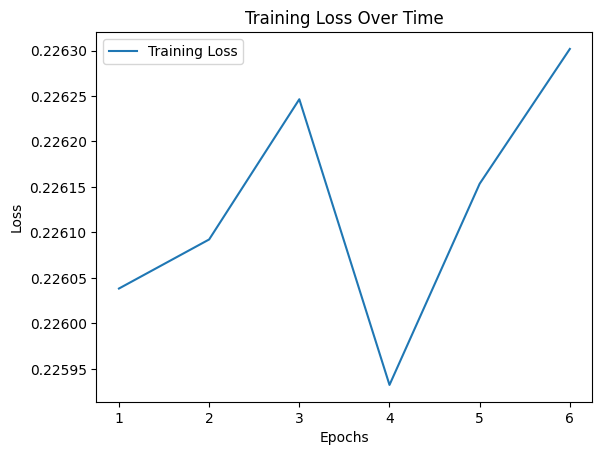

In [ ]:
#Training with 6 epochs

# Training
num_epochs = 6
loss_values = train(model, train_dataloader, optimizer, device, num_epochs)

# Save the model
#torch.save(model.state_dict(), "./custom_gpt_model.pth")
#tokenizer.save_pretrained("./custom_gpt_tokenizer")

# Plot the training loss
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [ ]:
def generate_text(model, tokenizer, prompt, max_length=100):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    position_ids = torch.arange(0, input_ids.size(1), dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_ids, position_ids)

    generated_text = tokenizer.decode(outputs[0, :].argmax(dim=-1).tolist(), skip_special_tokens=True)
    return generated_text

# Load the trained model (if not already loaded)
model = GPT2(GPT2Config())
model.load_state_dict(torch.load("./custom_gpt_model.pth"))
model.to(device)

# Example prompts for text generation
prompts = [
    "Einstein's theory of general relativity",

]

for prompt in prompts:
    print(f"Prompt: {prompt}")
    generated_text = generate_text(model, tokenizer, prompt)
    print(f"Generated Text: {generated_text}\n")


Prompt: Einstein's theory of general relativity
Generated Text: insteinthy theory of general pipes theory



##Model training with Tokenization

In [ ]:
!pip install torch transformers datasets

In [ ]:
!export CUDA_LAUNCH_BLOCKING=1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, AdamW
from datasets import load_dataset
import math
import matplotlib.pyplot as plt

# Step 1: Model Configuration
class GPTConfig:
    def __init__(self, vocab_size=50257, n_positions=1024, n_embd=768, n_layer=12, n_head=12, n_inner=3072):
        self.vocab_size = vocab_size
        self.n_positions = n_positions
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_inner = n_inner

# Step 2: Model Architecture
class GPT(nn.Module):
    def __init__(self, config):
        super(GPT, self).__init__()
        self.embed = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_embed = nn.Embedding(config.n_positions, config.n_embd)
        self.drop = nn.Dropout(0.1)
        self.layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, input_ids, position_ids):
        inputs_embeds = self.embed(input_ids)
        position_embeds = self.pos_embed(position_ids)
        hidden_states = inputs_embeds + position_embeds
        hidden_states = self.drop(hidden_states)

        for block in self.layers:
            hidden_states = block(hidden_states)

        hidden_states = self.ln_f(hidden_states)
        logits = self.head(hidden_states)
        return logits

class Block(nn.Module):
    def __init__(self, config):
        super(Block, self).__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, config.n_inner),
            nn.GELU(),
            nn.Linear(config.n_inner, config.n_embd),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        h = x
        x = self.ln_1(x)
        x = self.attn(x)
        x = h + x
        h = x
        x = self.ln_2(x)
        x = self.mlp(x)
        x = h + x
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super(MultiHeadAttention, self).__init__()
        self.n_head = config.n_head
        self.split_size = config.n_embd // config.n_head

        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(0.1)
        self.resid_dropout = nn.Dropout(0.1)
        self.scale = 1 / math.sqrt(self.split_size)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        query, key, value = self.c_attn(x).split(self.split_size * self.n_head, dim=2)
        query = query.view(batch_size, seq_length, self.n_head, self.split_size).transpose(1, 2)
        key = key.view(batch_size, seq_length, self.n_head, self.split_size).transpose(1, 2)
        value = value.view(batch_size, seq_length, self.n_head, self.split_size).transpose(1, 2)

        attn_weights = torch.matmul(query, key.transpose(-2, -1)) * self.scale
        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, value)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_length, -1)
        attn_output = self.c_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)
        return attn_output

# Step 3: Data Preparation
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')

def tokenize_function(examples):
    return tokenizer(examples['text'], return_special_tokens_mask=True, truncation=True, padding='max_length', max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

class CustomDataset(Dataset):
    def __init__(self, tokenized_text):
        self.examples = tokenized_text

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i], dtype=torch.long)

train_dataset = CustomDataset(tokenized_datasets["input_ids"])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Step 4: Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = GPTConfig()
model = GPT(config).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

def train(model, dataloader, optimizer, device, num_epochs):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    loss_values = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in dataloader:
            inputs = batch.to(device)
            # Ensure inputs are within the vocabulary size
            inputs = torch.clamp(inputs, max=config.vocab_size-1)
            position_ids = torch.arange(inputs.size(1), dtype=torch.long, device=inputs.device)
            optimizer.zero_grad()
            outputs = model(inputs, position_ids)
            shift_logits = outputs[..., :-1, :].contiguous()
            shift_labels = inputs[..., 1:].contiguous()
            loss = loss_fn(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        loss_values.append(epoch_loss / len(dataloader))
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader)}")

    return loss_values

num_epochs = 3
loss_values = train(model, train_dataloader, optimizer, device, num_epochs)

# Plot the training loss
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

## GPT Model Architeacture

@startuml
title GPT Model Architecture

class GPT {
  - embed: nn.Embedding
  - pos_embed: nn.Embedding
  - drop: nn.Dropout
  - layers: nn.ModuleList
  - ln_f: nn.LayerNorm
  - head: nn.Linear

  + __init__(config: GPTConfig)
  + forward(input_ids: Tensor, position_ids: Tensor): Tensor
}

class GPTConfig {
  - vocab_size: int
  - n_positions: int
  - n_embd: int
  - n_layer: int
  - n_head: int
  - n_inner: int

  + __init__(vocab_size: int, n_positions: int, n_embd: int, n_layer: int, n_head: int, n_inner: int)
}

class Block {
  + forward(x: Tensor): Tensor
}

class MultiHeadAttention {
  + forward(x: Tensor): Tensor
}

GPT "1" *-- "n" Block
Block *-- MultiHeadAttention

GPTConfig --> GPT : uses
GPTConfig : vocab_size: 50257
GPTConfig : n_positions: 1024
GPTConfig : n_embd: 768
GPTConfig : n_layer: 12
GPTConfig : n_head: 12
GPTConfig : n_inner: 3072

GPT : + embed: nn.Embedding
GPT : + pos_embed: nn.Embedding
GPT : + drop: nn.Dropout
GPT : + layers: nn.ModuleList
GPT : + ln_f: nn.LayerNorm
GPT : + head: nn.Linear
@enduml

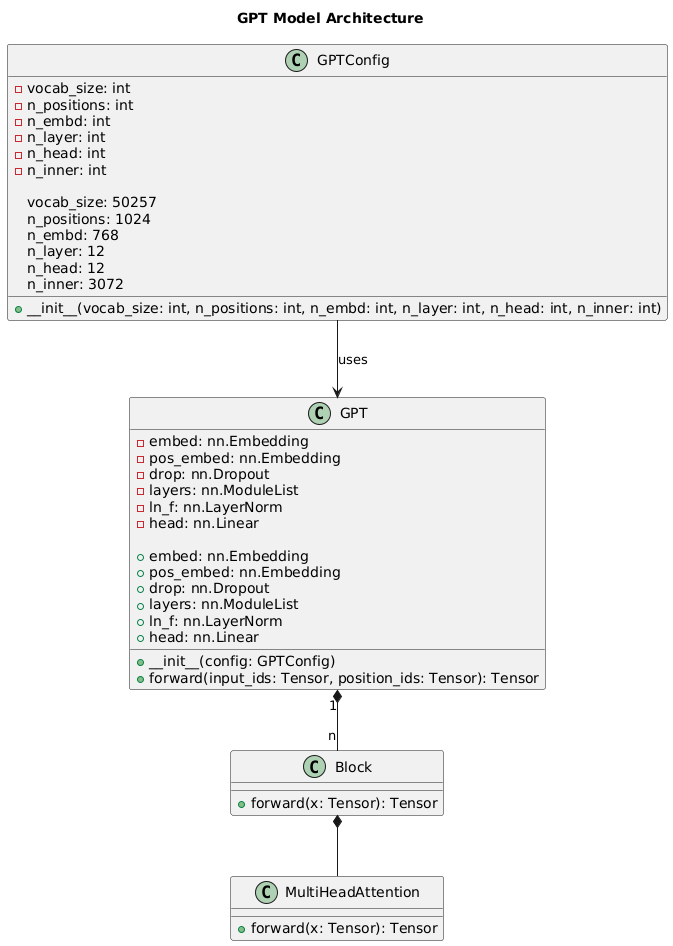

##Try2

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Loss: 1.6785795163022341
Epoch 2/3, Loss: 0.42538802975161216
Epoch 3/3, Loss: 0.1462218441188167


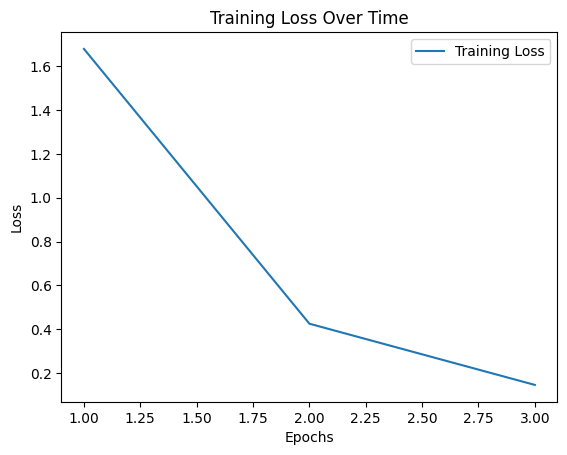

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, AdamW
from datasets import load_dataset
import math
import matplotlib.pyplot as plt

# Step 1: Model Configuration
class GPTConfig:
    def __init__(self, vocab_size=50257, n_positions=1024, n_embd=768, n_layer=12, n_head=12, n_inner=3072):
        self.vocab_size = vocab_size
        self.n_positions = n_positions
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_inner = n_inner

# Step 2: Model Architecture
class GPT(nn.Module):
    def __init__(self, config):
        super(GPT, self).__init__()
        self.embed = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_embed = nn.Embedding(config.n_positions, config.n_embd)
        self.drop = nn.Dropout(0.1)
        self.layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, input_ids, position_ids):
        inputs_embeds = self.embed(input_ids)
        position_embeds = self.pos_embed(position_ids)
        hidden_states = inputs_embeds + position_embeds
        hidden_states = self.drop(hidden_states)

        for block in self.layers:
            hidden_states = block(hidden_states)

        hidden_states = self.ln_f(hidden_states)
        logits = self.head(hidden_states)
        return logits

class Block(nn.Module):
    def __init__(self, config):
        super(Block, self).__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, config.n_inner),
            nn.GELU(),
            nn.Linear(config.n_inner, config.n_embd),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        h = x
        x = self.ln_1(x)
        x = self.attn(x)
        x = h + x
        h = x
        x = self.ln_2(x)
        x = self.mlp(x)
        x = h + x
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super(MultiHeadAttention, self).__init__()
        self.n_head = config.n_head
        self.split_size = config.n_embd // config.n_head

        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(0.1)
        self.resid_dropout = nn.Dropout(0.1)
        self.scale = 1 / math.sqrt(self.split_size)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        query, key, value = self.c_attn(x).split(self.split_size * self.n_head, dim=2)
        query = query.view(batch_size, seq_length, self.n_head, self.split_size).transpose(1, 2)
        key = key.view(batch_size, seq_length, self.n_head, self.split_size).transpose(1, 2)
        value = value.view(batch_size, seq_length, self.n_head, self.split_size).transpose(1, 2)

        attn_weights = torch.matmul(query, key.transpose(-2, -1)) * self.scale
        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, value)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_length, -1)
        attn_output = self.c_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)
        return attn_output

# Step 3: Data Preparation
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

dataset = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')

def tokenize_function(examples):
    return tokenizer(examples['text'], return_special_tokens_mask=True, truncation=True, padding='max_length', max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

class CustomDataset(Dataset):
    def __init__(self, tokenized_text):
        self.examples = tokenized_text

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i], dtype=torch.long)

train_dataset = CustomDataset(tokenized_datasets["input_ids"])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Step 4: Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = GPTConfig()
model = GPT(config).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

def train(model, dataloader, optimizer, device, num_epochs):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    loss_values = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in dataloader:
            inputs = batch.to(device)
            # Ensure inputs are within the vocabulary size
            inputs = torch.clamp(inputs, max=config.vocab_size-1)
            position_ids = torch.arange(inputs.size(1), dtype=torch.long, device=inputs.device)
            optimizer.zero_grad()
            outputs = model(inputs, position_ids)
            shift_logits = outputs[..., :-1, :].contiguous()
            shift_labels = inputs[..., 1:].contiguous()
            loss = loss_fn(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        loss_values.append(epoch_loss / len(dataloader))
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader)}")

    return loss_values

num_epochs = 3
loss_values = train(model, train_dataloader, optimizer, device, num_epochs)

# Plot the training loss
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()




In [ ]:
# Save the model
model_save_path = 'gpt_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to gpt_model.pth


In [ ]:
# Step 5: Text Generation and Model Evaluation
def generate_text(model, tokenizer, prompt, max_length=50):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device).unsqueeze(0)

    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(input_ids, position_ids)
            next_token_logits = outputs[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
            input_ids = torch.cat((input_ids, next_token), dim=1)
            position_ids = torch.cat((position_ids, torch.tensor([[position_ids[0, -1] + 1]], device=input_ids.device)), dim=1)

    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

def evaluate_model(model, tokenizer, dataloader, device):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    total_steps = 0

    for batch in dataloader:
        inputs = batch.to(device)
        # Ensure inputs are within the vocabulary size
        inputs = torch.clamp(inputs, max=config.vocab_size-1)
        position_ids = torch.arange(inputs.size(1), dtype=torch.long, device=inputs.device)

        with torch.no_grad():
            outputs = model(inputs, position_ids)
            shift_logits = outputs[..., :-1, :].contiguous()
            shift_labels = inputs[..., 1:].contiguous()
            loss = loss_fn(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            total_loss += loss.item()
            total_steps += 1

    avg_loss = total_loss / total_steps
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity

# Example usage
prompt = "Once upon a time"
generated_text = generate_text(model, tokenizer, prompt)
print(f"Generated text: {generated_text}")

# Evaluate the model
eval_loss, eval_perplexity = evaluate_model(model, tokenizer, train_dataloader, device)
print(f"Evaluation Loss: {eval_loss}, Perplexity: {eval_perplexity}")

In [ ]:
# Save the model
model_save_path = 'gpt_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

In [ ]:
# Load the model
model_load_path = 'gpt_model.pth'
loaded_model = GPT(config).to(device)
loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.eval()
print(f"Model loaded from {model_load_path}")

# Evaluate the loaded model
eval_loss, eval_perplexity = evaluate_model(loaded_model, tokenizer, train_dataloader, device)
print(f"Evaluation Loss: {eval_loss}, Perplexity: {eval_perplexity}")